# Libraries

In [1]:
import pandas as pd; print("Pandas Version: ", pd.__version__)
import numpy as np; print("Numpy Version: ", np.__version__)
import torch; print("PyTorch Version: ", torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

WANDB = False

Pandas Version:  1.5.3
Numpy Version:  1.24.2
PyTorch Version:  1.13.1+cu117


In [2]:
try :
  from google.colab import drive
  IN_COLAB = True

  drive.mount('/content/drive/')
  import os
  os.chdir("/content/drive/My Drive/Colab Notebooks/")
  if WANDB :
    ! pip install wandb -qU

except :
  IN_COLAB = False
if WANDB :
  import wandb
  wandb.login()

In [3]:
if IN_COLAB and WANDB:
    run = wandb.init(project='font_creation')

# Import data

In [4]:

# import data from csv file
path = 'dataset/csv/images.csv'
data_input = pd.read_csv('dataset/csv/images.csv')

# convert data to torch tensor
data = torch.from_numpy(data_input.values)
print(data.shape)

torch.Size([1674, 20384])


In [5]:
font_count, size = data.shape
alphabet = 26
image_size = 28
print("font_count: ", font_count)
print("size: ", size)
print("alphabet: ", alphabet)
print("image_size: ", image_size)

# reshape data to 26x28x28 tensor
data = data.reshape(font_count, alphabet, image_size, image_size)
print(data.shape)

font_count:  1674
size:  20384
alphabet:  26
image_size:  28
torch.Size([1674, 26, 28, 28])


# Graphic helpers

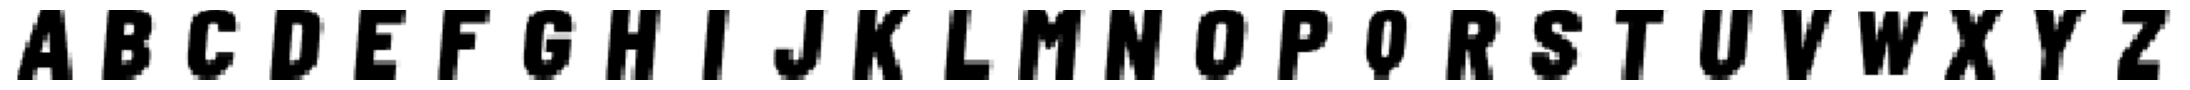

In [6]:

def show_font_tensor( font_tensor: torch.Tensor ) :
  assert font_tensor.shape == (alphabet, image_size, image_size), "font_tensor shape is not valid"

  # plot font image of 26 alphabets
  plt.subplots(1, alphabet, figsize=(image_size, image_size))

  for i in range(alphabet) :
    plt.subplot(1, 26, i+1)
    plt.axis('off')
    plt.imshow(font_tensor[i], cmap='gray')

  plt.show()

def show_font(font_index = np.random.randint(0, font_count)) :
  assert font_count > font_index, "font_index out of range"

  # get font image
  font = data[font_index]

  show_font_tensor(font)

# show random font image
show_font()

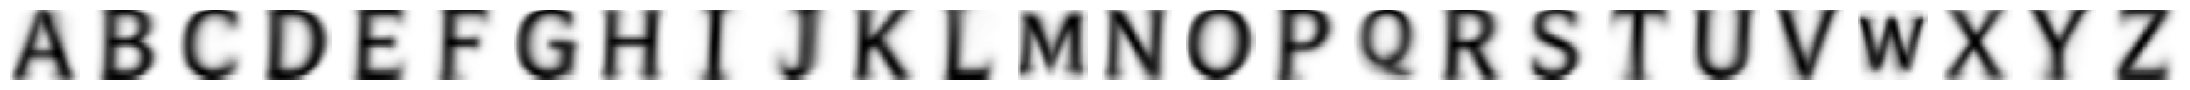

In [7]:
mean = data.mean(axis=0)
show_font_tensor(mean)

# Hyperparameters

In [8]:
class opt :
  n_epochs = 6000 if IN_COLAB else 50
  batch_size = 64
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  n_cpu = 8
  latent_dim = 100
  img_size = 28
  channels = 1
  sample_interval = 400

  channels = 26
  img_size = 28
  latent_dim = 100

  cutoff_threshold = 0.000001

# Generator and discriminator architectures

In [12]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

img_shape = (opt.channels, opt.img_size, opt.img_size)



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function

In [13]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Synthetic data generation

In [14]:
# define dataloader from data_2d

data_2d = data
dataloader = torch.utils.data.DataLoader(data_2d, batch_size=opt.batch_size, shuffle=True)

# Main training loop

In [19]:
losses = []
abort = False
for epoch in range(opt.n_epochs):
    if abort:
        break

    print("Epoch %d/%d" %(epoch,opt.n_epochs))

    for i, (imgs) in enumerate(dataloader):
        # Adversarial ground truths



        valid = Variable(
            Tensor(imgs.size(0), 1).uniform_(0.85,1.10), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).uniform_(0.0, 0.2), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()



        if IN_COLAB and WANDB:
            wandb.log({
            "D loss":d_loss.item(),
            "G loss":g_loss.item(),
            "real loss":real_loss.item(),
            "fake loss":fake_loss.item()
            })
        losses.append((d_loss.item(), g_loss.item()))
        if d_loss.item() < opt.cutoff_threshold or g_loss.item() < opt.cutoff_threshold:
            abort = True
            break
        batches_done = epoch * len(dataloader) + i

if IN_COLAB and WANDB:
    path = 'weights/'
    if os.path.isdir(path) == False:
        os.mkdir(path)
    torch.save(generator.state_dict(), path +'generator.pth')
    torch.save(discriminator.state_dict(), path + 'discriminator.pth')
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file(path +'generator.pth')
    artifact.add_file(path+'discriminator.pth')
    run.log_artifact(artifact)
    run.finish()


Epoch 0/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50


# Post-training analysis

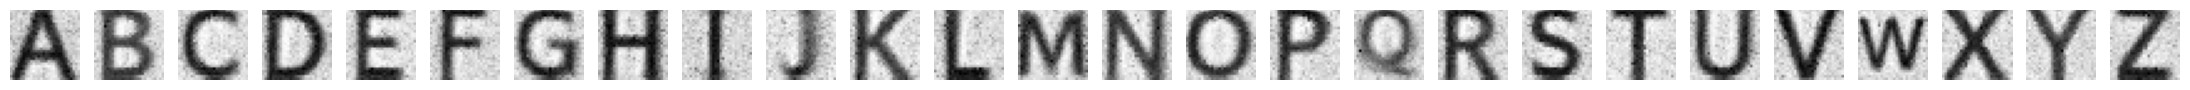

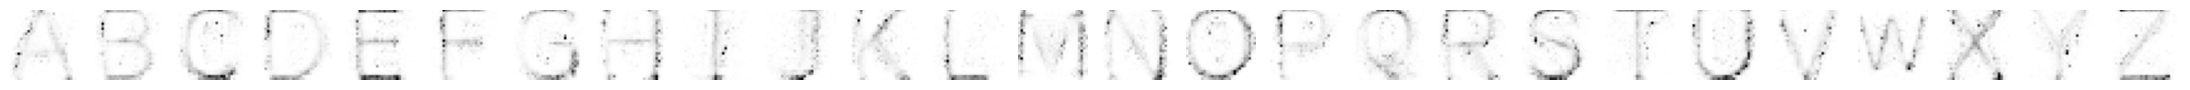

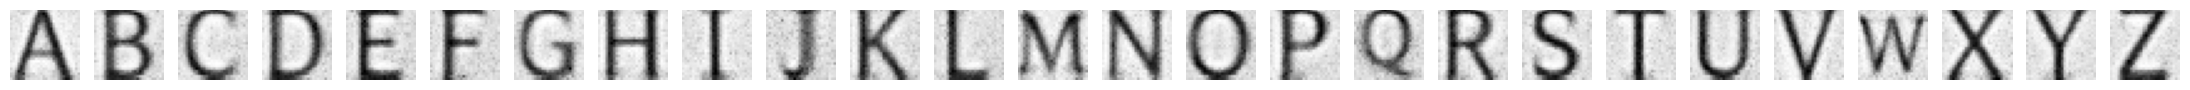

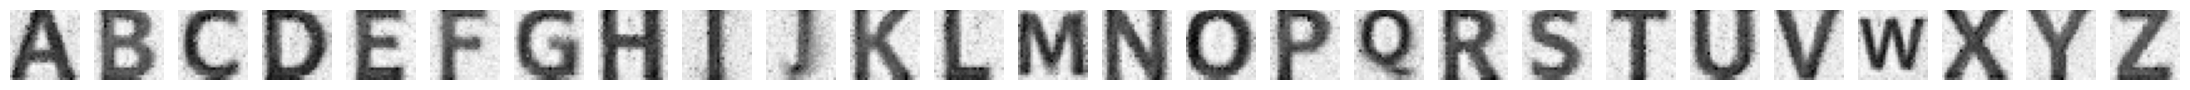

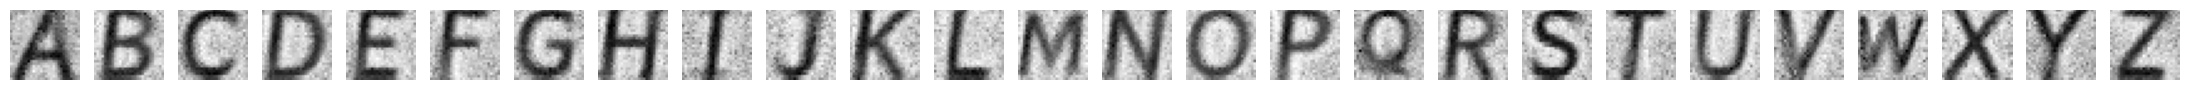

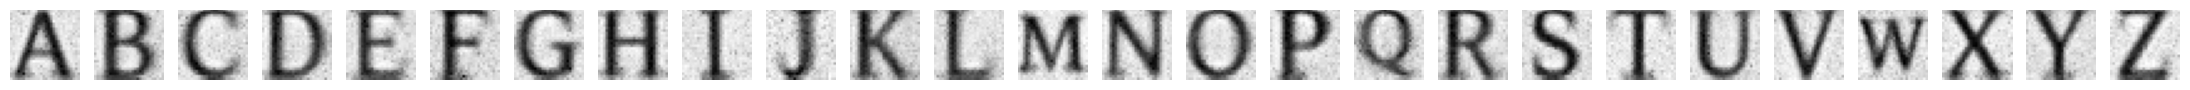

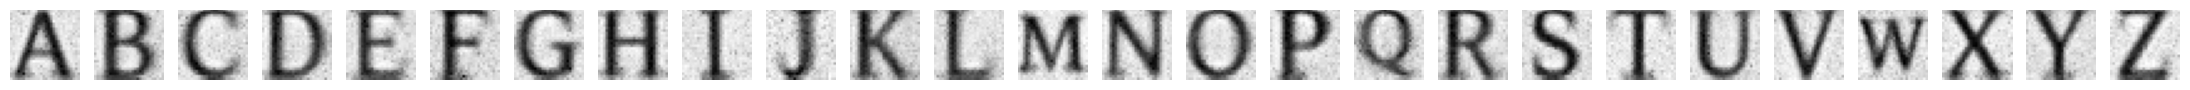

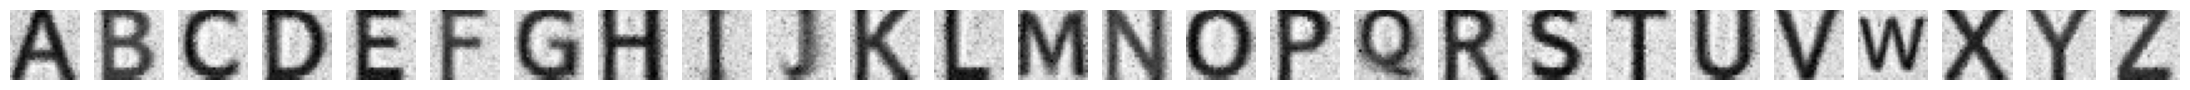

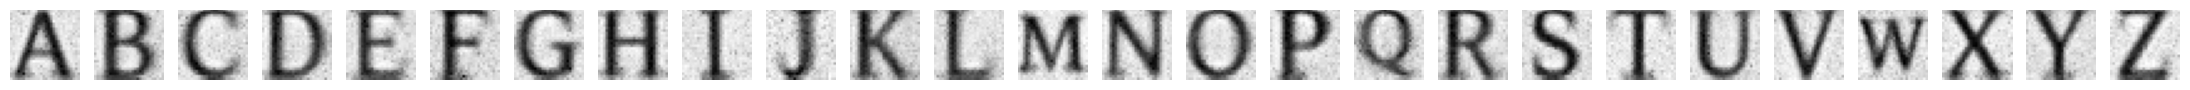

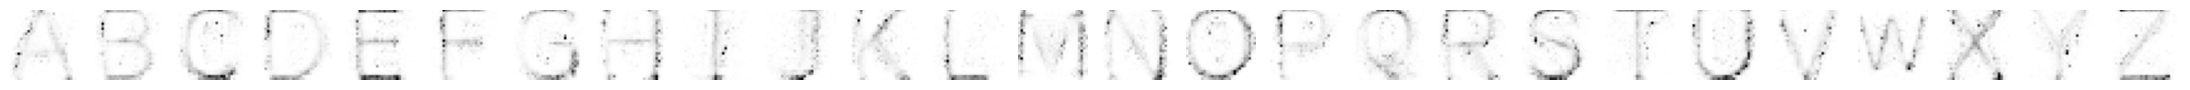

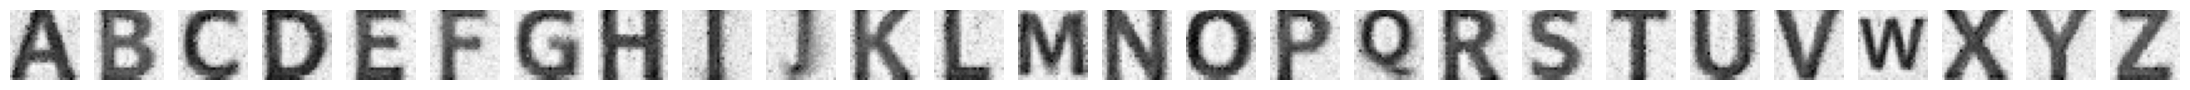

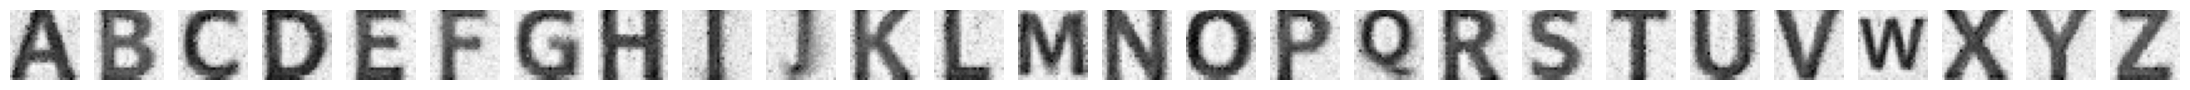

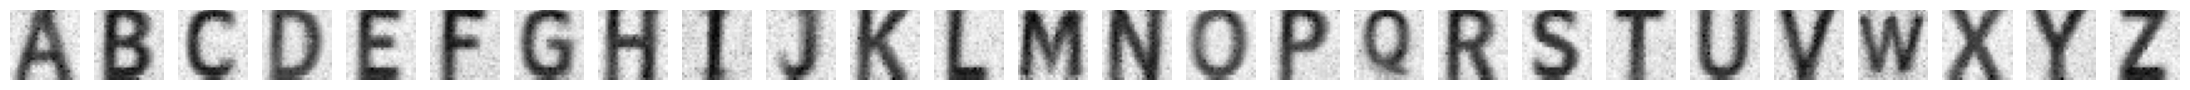

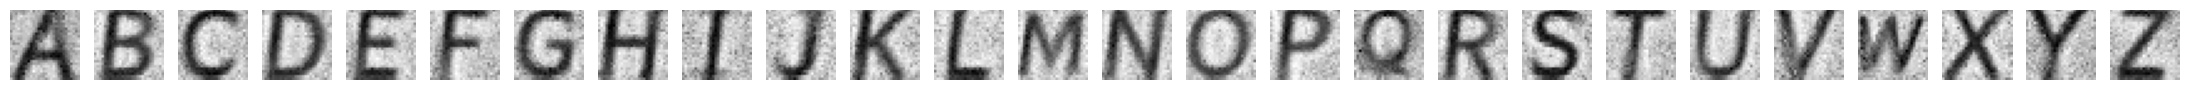

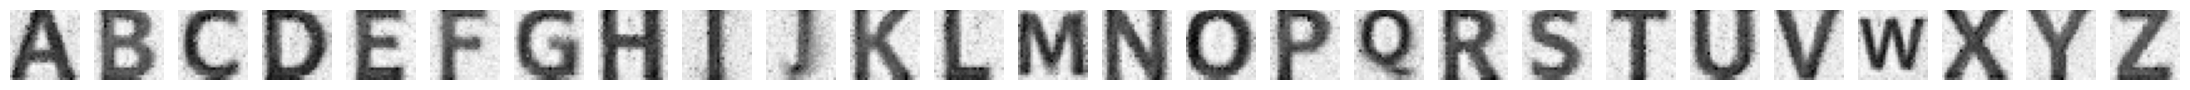

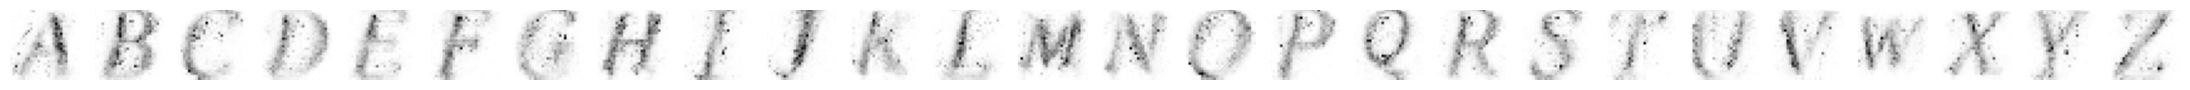

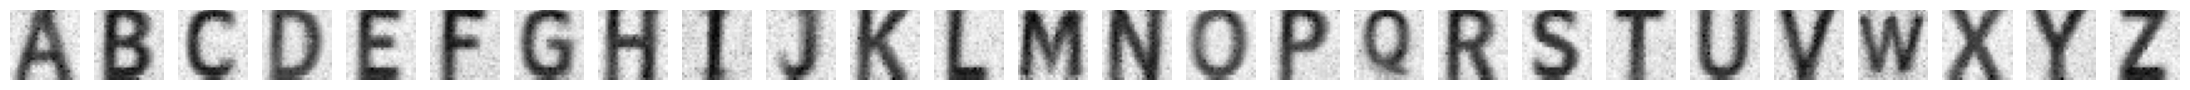

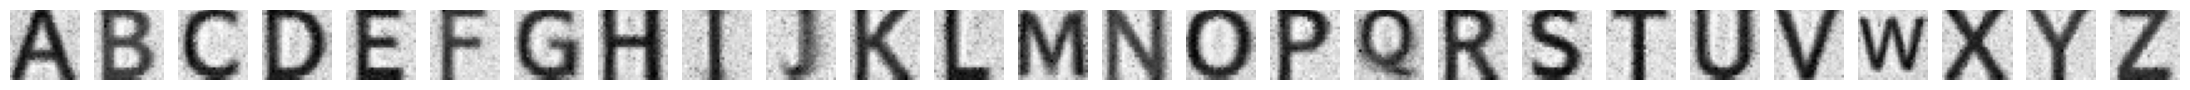

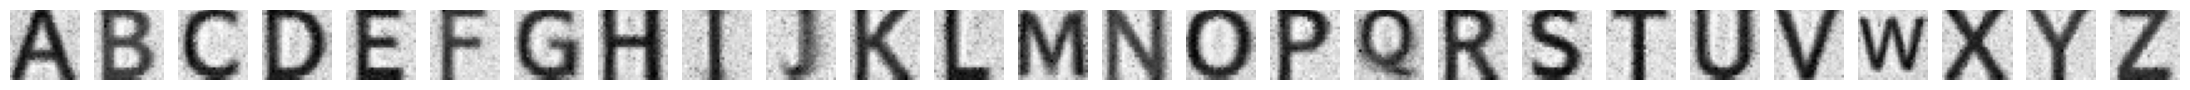

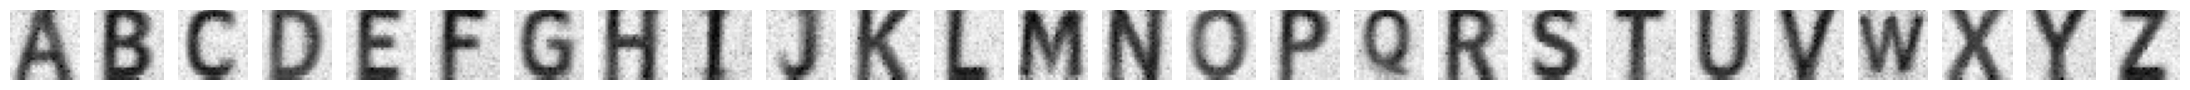

In [20]:
indices = list(range(len(gen_imgs)))
indices = np.random.choice(indices,20)
for i in indices :
  show_font_tensor(gen_imgs[i].detach().cpu().numpy())

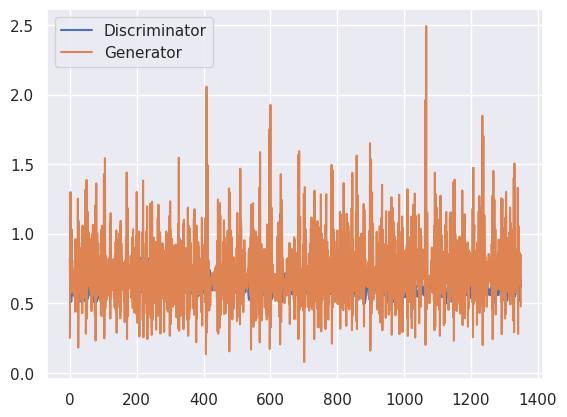

In [21]:
plt.plot(losses)
plt.legend(['Discriminator', 'Generator'])
plt.show()

In [22]:
# save losses as backup 
path = 'dataset/losses/'
if os.path.isdir(path) == False:
    os.mkdir(path)
name = "loss_with_noise" + str(time.time())
# save csv file
pd.DataFrame(losses).to_csv(path + name + '.csv', index=False)
